In [1]:
!pip install pytorch-lightning

In [2]:
!pip install torchmetrics

In [3]:
!pip install timm

In [4]:
!pip install torchsummary

In [5]:
import os
import random
import shutil
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.metrics import classification_report
import seaborn as sns
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping
import torch
import torchvision.models as models
from torchsummary import summary
import timm
from torchmetrics import Accuracy
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torch
from pytorch_lightning.callbacks import ModelCheckpoint

2024-05-24 11:17:41.938310: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-24 11:17:41.938403: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-24 11:17:42.107678: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [6]:
right_folder = '/kaggle/input/img-raw/Img_Augmented/Img_Augmented/0'
wrong_folder = '/kaggle/input/img-raw/Img_Augmented/Img_Augmented/1'
test_folder = '/kaggle/working/Ring/Img_Test'
train_folder = '/kaggle/working/Ring/Img_Train'

In [7]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

In [8]:
len(all_files)

4800

In [9]:
filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]
X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [10]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)
    
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [13]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 53 * 53, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
class MyLitModel(pl.LightningModule):
    def __init__(self, lr=0.001):
        super(MyLitModel, self).__init__()
        self.model = Net()
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        self.lr = lr
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_preds.append(torch.round(torch.sigmoid(preds)).cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

In [18]:
model = MyLitModel(lr=0.001)

In [20]:
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_raw/',
    filename='ring-raw-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [21]:
trainer.fit(model, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [23]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-raw/test_img/test_img', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [24]:
best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8287037014961243     │
│      test_loss_epoch      │    1.7370966672897339     │
└───────────────────────────┴───────────────────────────┘

In [25]:
best_model_path

'/kaggle/working/Model_raw/ring-raw-epoch=14-val_loss=0.01.ckpt'

In [26]:
from IPython.display import FileLink
FileLink(r'Model_raw/ring-raw-epoch=14-val_loss=0.01.ckpt')

/kaggle/working/Model_raw/ring-raw-epoch=14-val_loss=0.01.ckpt

In [27]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [28]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

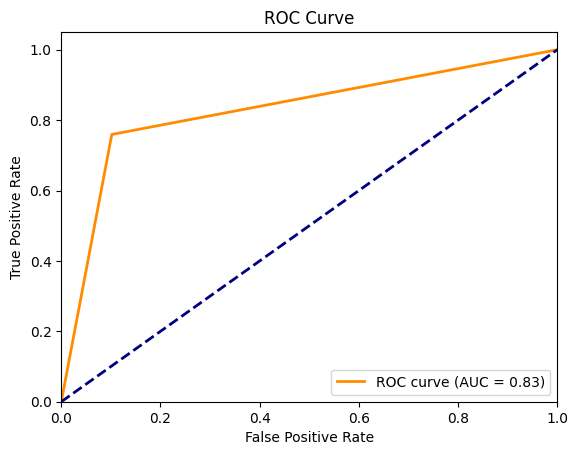

In [29]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

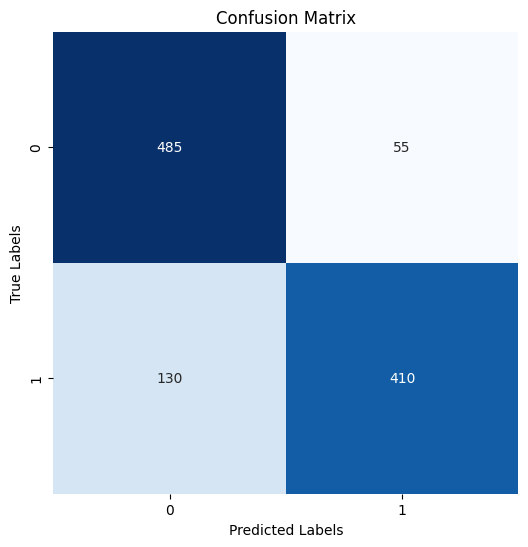

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       540
           1       0.88      0.76      0.82       540

    accuracy                           0.83      1080
   macro avg       0.84      0.83      0.83      1080
weighted avg       0.84      0.83      0.83      1080



In [30]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [42]:
right_folder = '/kaggle/input/img-mask/Img_Mask/Img_Mask/0'
wrong_folder = '/kaggle/input/img-mask/Img_Mask/Img_Mask/1'
test_folder = '/kaggle/working/Ring/Mask/Img_Test'
train_folder = '/kaggle/working/Ring/Mask/Img_Train'

In [43]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [44]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)
    
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [35]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [37]:
model_mask = MyLitModel(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_mask/',
    filename='ring-mask-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [38]:
trainer.fit(model_mask, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [39]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-mask/test_img_mask/test_img_mask', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │     0.824999988079071     │
│      test_loss_epoch      │    1.2847040891647339     │
└───────────────────────────┴───────────────────────────┘

In [40]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [41]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

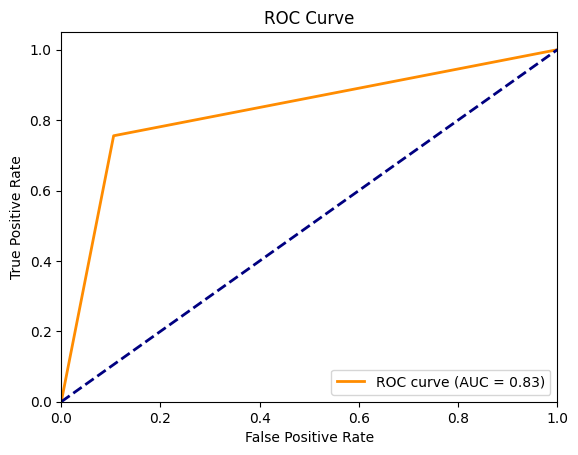

In [42]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

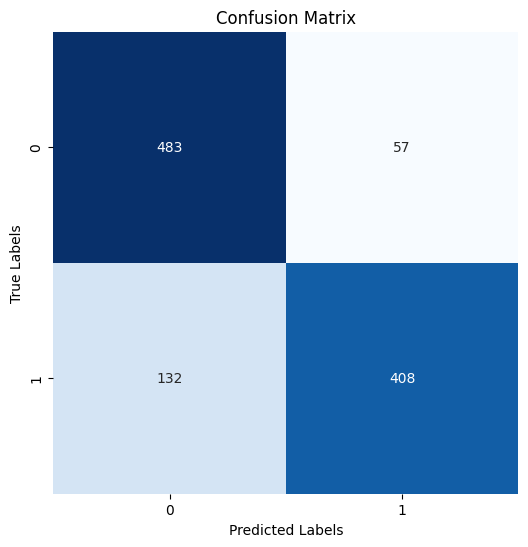

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       540
           1       0.88      0.76      0.81       540

    accuracy                           0.82      1080
   macro avg       0.83      0.82      0.82      1080
weighted avg       0.83      0.82      0.82      1080



In [43]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [44]:
best_model_path

'/kaggle/working/Model_mask/ring-mask-epoch=14-val_loss=0.01.ckpt'

In [45]:
from IPython.display import FileLink
FileLink(r'Model_mask/ring-mask-epoch=14-val_loss=0.01.ckpt')

/kaggle/working/Model_mask/ring-mask-epoch=14-val_loss=0.01.ckpt

In [47]:
right_folder = '/kaggle/input/img-no-sha/Img_no_sha/Img_no_sha/0'
wrong_folder = '/kaggle/input/img-no-sha/Img_no_sha/Img_no_sha/1'
test_folder = '/kaggle/working/Ring/No_Sha/Img_Test'
train_folder = '/kaggle/working/Ring/No_Sha/Img_Train'

In [48]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [49]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)
    
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [50]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [51]:
model_no_sha_mask = MyLitModel(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_no_sha/',
    filename='ring-nosha-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [52]:
trainer.fit(model_no_sha_mask, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [53]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-no-sha/test_img_no_sha/test_img_no_sha', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.7333333492279053     │
│      test_loss_epoch      │    1.4312806129455566     │
└───────────────────────────┴───────────────────────────┘

In [54]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [55]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

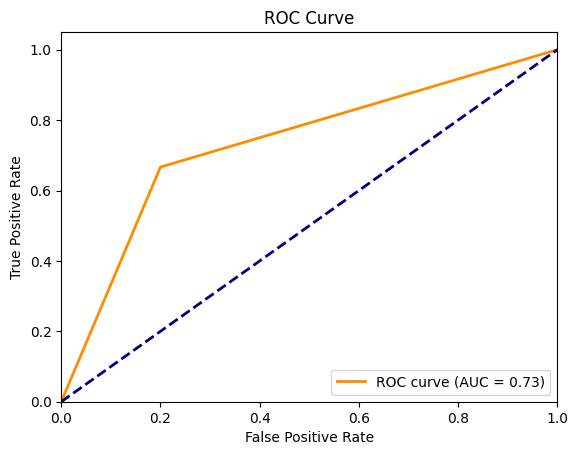

In [56]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

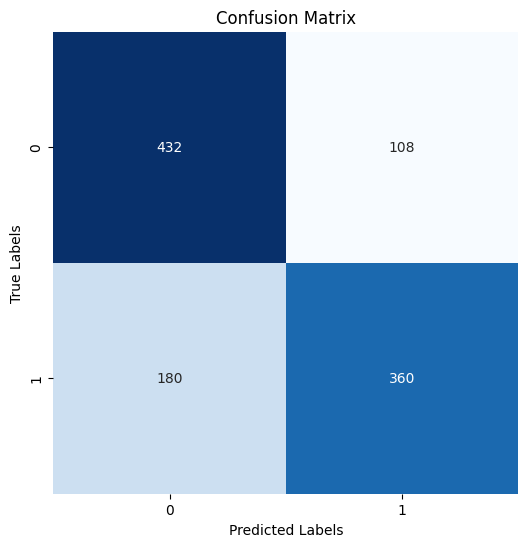

              precision    recall  f1-score   support

           0       0.71      0.80      0.75       540
           1       0.77      0.67      0.71       540

    accuracy                           0.73      1080
   macro avg       0.74      0.73      0.73      1080
weighted avg       0.74      0.73      0.73      1080



In [57]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [9]:
right_folder = '/kaggle/input/img-ycr/Img_yc/Img_yc/0'
wrong_folder = '/kaggle/input/img-ycr/Img_yc/Img_yc/1'
test_folder = '/kaggle/working/Ring/yc/Img_Test'
train_folder = '/kaggle/working/Ring/yc/Img_Train'

In [10]:
right_files = [(os.path.join(right_folder, file), 0) for file in os.listdir(right_folder) if file.endswith('.jpg')]
wrong_files = [(os.path.join(wrong_folder, file), 1) for file in os.listdir(wrong_folder) if file.endswith('.jpg')]
all_files = right_files + wrong_files

filenames = [file[0] for file in all_files]
labels = [file[1] for file in all_files]

X_train_filenames, X_test_filenames, y_train, y_test = train_test_split(filenames, labels, test_size=0.2, random_state=42)

os.makedirs(test_folder, exist_ok=True)
os.makedirs(train_folder, exist_ok=True)

In [11]:
for filename, label in zip(X_train_filenames, y_train):
    dst_folder = os.path.join(train_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)
    
for filename, label in zip(X_test_filenames, y_test):
    dst_folder = os.path.join(test_folder, str(label))
    os.makedirs(dst_folder, exist_ok=True)
    shutil.copy(filename, dst_folder)

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_folder, transform=transform)
val_dataset = datasets.ImageFolder(root=test_folder, transform=transform)

batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=NUM_WORKERS)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=NUM_WORKERS)

In [13]:
model_yc = MyLitModel(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_yc/',
    filename='ring-yc-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [14]:
trainer.fit(model_yc, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [15]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-ycr/test_img_yc/test_img_yc', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

best_model_path = checkpoint_callback.best_model_path
model = MyLitModel.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8194444179534912     │
│      test_loss_epoch      │    1.6027520895004272     │
└───────────────────────────┴───────────────────────────┘

In [ ]:
best_model_path

In [ ]:
from IPython.display import FileLink
FileLink(r'Model_yc/middle-yc-epoch=14-val_loss=0.01.ckpt')

In [16]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [17]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

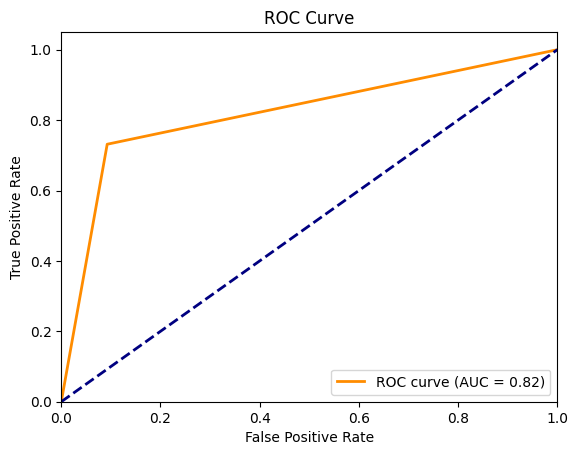

In [18]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

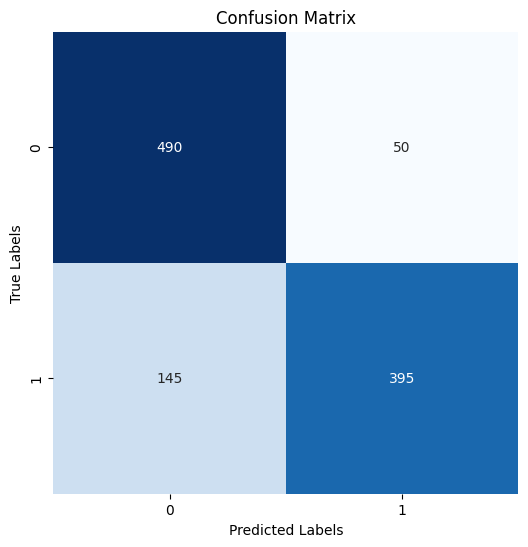

              precision    recall  f1-score   support

           0       0.77      0.91      0.83       540
           1       0.89      0.73      0.80       540

    accuracy                           0.82      1080
   macro avg       0.83      0.82      0.82      1080
weighted avg       0.83      0.82      0.82      1080



In [19]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [11]:
test_folder = '/kaggle/working/Ring/Img_Test'
train_folder = '/kaggle/working/Ring/Img_Train'

In [12]:
model_eva = timm.create_model('eva02_tiny_patch14_336.mim_in22k_ft_in1k', pretrained=True)
model_eva = model_eva.eval()

data_config = timm.data.resolve_model_data_config(model_eva)
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)

model.safetensors:   0%|          | 0.00/23.0M [00:00<?, ?B/s]

In [13]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [14]:
class LitEva02(pl.LightningModule):
    def __init__(self, num_classes=1, lr=0.001):
        super(LitEva02, self).__init__()
        self.model = timm.create_model('eva02_tiny_patch14_336.mim_in22k_ft_in1k', pretrained=True, num_classes=num_classes)
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        self.lr = lr
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_preds.append(torch.round(torch.sigmoid(preds)).cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

In [15]:
model_eva02_raw = LitEva02(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_raw_eva_up/',
    filename='ring-eva02-raw-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_Eva02 = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [16]:
trainer_Eva02.fit(model_eva02_raw, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [17]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-raw/test_img/test_img', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

In [18]:
best_model_path = checkpoint_callback.best_model_path
model = LitEva02.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9555555582046509     │
│      test_loss_epoch      │    0.09362240880727768    │
└───────────────────────────┴───────────────────────────┘

In [19]:
best_model_path

'/kaggle/working/Model_raw_eva_up/ring-eva02-raw-cnn-epoch=12-val_loss=0.00.ckpt'

In [20]:
from IPython.display import FileLink
FileLink(r'Model_raw_eva_up/ring-eva02-raw-cnn-epoch=12-val_loss=0.00.ckpt')

/kaggle/working/Model_raw_eva_up/ring-eva02-raw-cnn-epoch=12-val_loss=0.00.ckpt

In [21]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [ ]:
test_preds

In [22]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

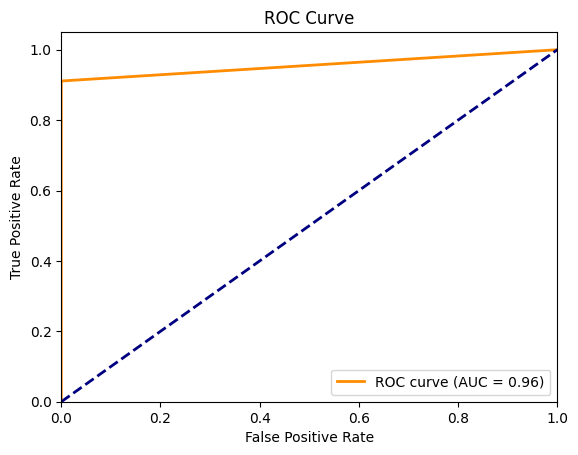

In [23]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

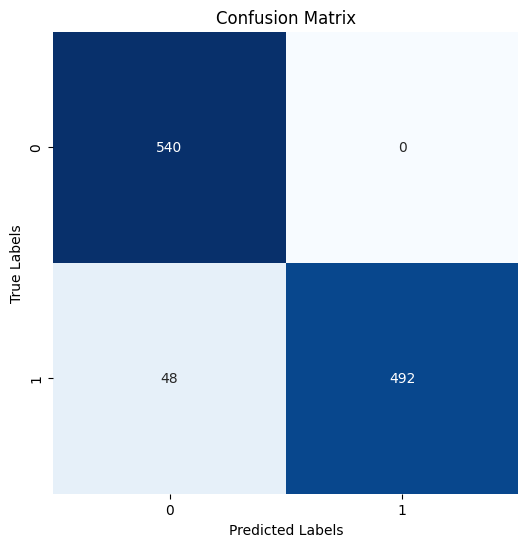

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       540
           1       1.00      0.91      0.95       540

    accuracy                           0.96      1080
   macro avg       0.96      0.96      0.96      1080
weighted avg       0.96      0.96      0.96      1080



In [24]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [25]:
model_effnet = timm.create_model('efficientnet_b2.ra_in1k', pretrained=True)
model_effnet = model_effnet.eval()

data_config = timm.data.resolve_model_data_config(model_effnet)
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)

model.safetensors:   0%|          | 0.00/36.8M [00:00<?, ?B/s]

In [27]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [30]:
class LitEffnet(pl.LightningModule):
    def __init__(self, num_classes=1, lr=0.001):
        super(LitEffnet, self).__init__()
        self.model = timm.create_model('efficientnet_b2.ra_in1k', pretrained=True, num_classes=num_classes)
        self.train_accuracy = Accuracy(task="binary")
        self.val_accuracy = Accuracy(task="binary")
        self.test_accuracy = Accuracy(task="binary")
        self.lr = lr
        self.test_preds = []
        self.test_labels = []

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('val_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        labels = labels.view(-1, 1)
        preds = self(images)
        acc = self.train_accuracy(torch.sigmoid(preds), labels.int())
        loss = nn.BCELoss()(torch.sigmoid(preds), labels.float())
        self.log('test_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.test_preds.append(torch.round(torch.sigmoid(preds)).cpu().numpy())
        self.test_labels.append(labels.cpu().numpy())
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.SGD(self.parameters(), lr=0.001, momentum=0.9)
        return optimizer

In [31]:
model_effnet_raw = LitEffnet(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_effnet_raw/',
    filename='ring-effnet_raw-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_Effnet = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [32]:
trainer_Effnet.fit(model_effnet_raw, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [33]:
best_model_path = checkpoint_callback.best_model_path
model = LitEffnet.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8916666507720947     │
│      test_loss_epoch      │    0.38986173272132874    │
└───────────────────────────┴───────────────────────────┘

In [34]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [35]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

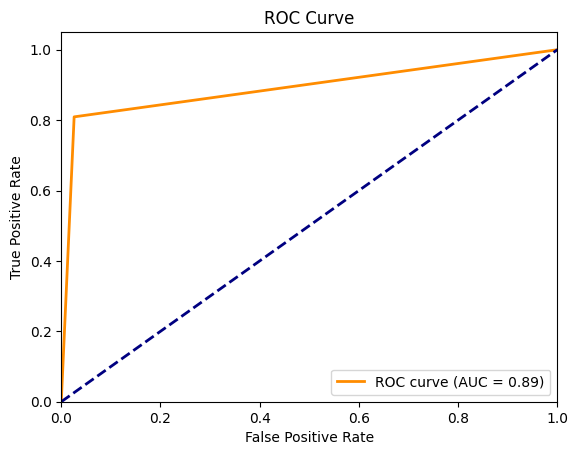

In [36]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

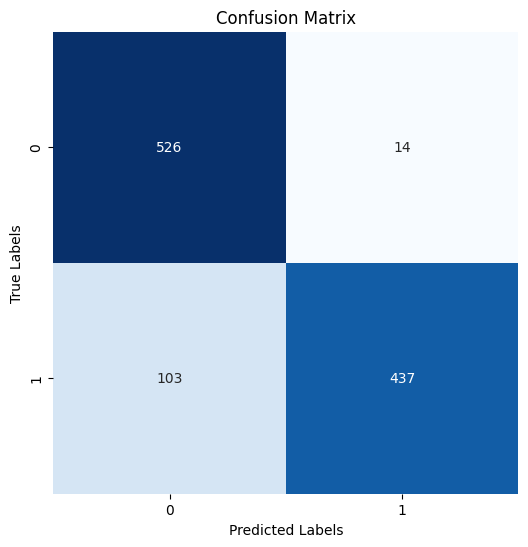

              precision    recall  f1-score   support

           0       0.84      0.97      0.90       540
           1       0.97      0.81      0.88       540

    accuracy                           0.89      1080
   macro avg       0.90      0.89      0.89      1080
weighted avg       0.90      0.89      0.89      1080



In [37]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [38]:
best_model_path

'/kaggle/working/Model_effnet_raw/middle-effnet_raw-cnn-epoch=13-val_loss=0.00.ckpt'

In [39]:
from IPython.display import FileLink
FileLink(r'Model_effnet_raw/middle-effnet_raw-cnn-epoch=13-val_loss=0.00.ckpt')

/kaggle/working/Model_effnet_raw/middle-effnet_raw-cnn-epoch=13-val_loss=0.00.ckpt

In [45]:
test_folder = '/kaggle/working/Ring/Mask/Img_Test'
train_folder = '/kaggle/working/Ring/Mask/Img_Train'

In [46]:
model_eva = timm.create_model('eva02_tiny_patch14_336.mim_in22k_ft_in1k', pretrained=True)
model_eva = model_eva.eval()

data_config = timm.data.resolve_model_data_config(model_eva)
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)

batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [47]:
model_eva02_mask = LitEva02(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_eva02_mask/',
    filename='ring-eva02_mask-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_Eva02_mask = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [48]:
trainer_Eva02_mask.fit(model_eva02_mask, train_loader, val_loader)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [53]:
test_dataset = datasets.ImageFolder(root='/kaggle/input/img-mask/test_img_mask/test_img_mask', transform=val_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=3)

In [50]:
best_model_path = checkpoint_callback.best_model_path
model = LitEva02.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.9064815044403076     │
│      test_loss_epoch      │    0.4770745635032654     │
└───────────────────────────┴───────────────────────────┘

In [51]:
best_model_path

'/kaggle/working/Model_eva02_mask/ring-eva02_mask-cnn-epoch=11-val_loss=0.00.ckpt'

In [52]:
from IPython.display import FileLink
FileLink(r'Model_eva02_mask/ring-eva02_mask-cnn-epoch=11-val_loss=0.00.ckpt')

/kaggle/working/Model_eva02_mask/ring-eva02_mask-cnn-epoch=11-val_loss=0.00.ckpt

In [55]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [56]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

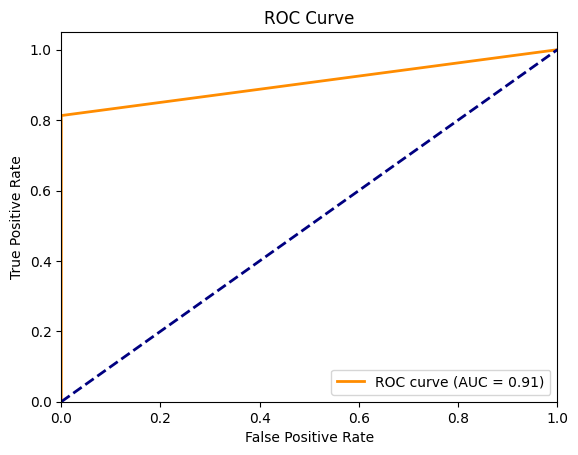

In [57]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

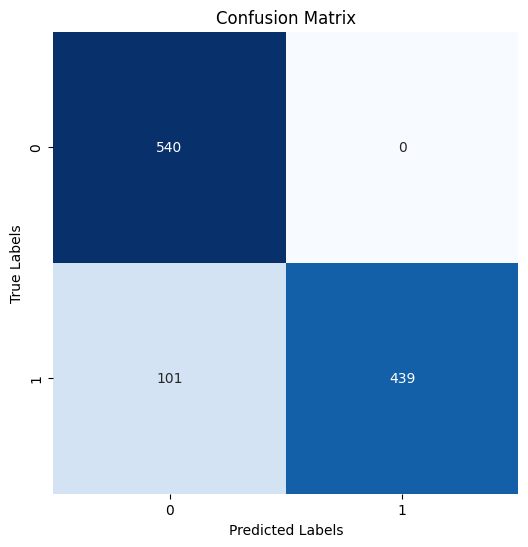

              precision    recall  f1-score   support

           0       0.84      1.00      0.91       540
           1       1.00      0.81      0.90       540

    accuracy                           0.91      1080
   macro avg       0.92      0.91      0.91      1080
weighted avg       0.92      0.91      0.91      1080



In [58]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))

In [68]:
model_effnet = timm.create_model('efficientnet_b2.ra_in1k', pretrained=True)
model_effnet = model_effnet.eval()

data_config = timm.data.resolve_model_data_config(model_effnet)
train_transforms = timm.data.create_transform(**data_config, is_training=True)
val_transforms = timm.data.create_transform(**data_config, is_training=False)

train_dataset = datasets.ImageFolder(root=train_folder, transform=train_transforms)
val_dataset = datasets.ImageFolder(root=test_folder, transform=val_transforms)

In [69]:
batch_size = 32
NUM_WORKERS = int(os.cpu_count() / 2)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=3)

In [70]:
model_effnet_mask = LitEffnet(lr=0.001)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='/kaggle/working/Model_effnet_mask/',
    filename='ring-effnet_mask-cnn-{epoch:02d}-{val_loss:.2f}',
    save_top_k=3,
    mode='min',
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=5,
    mode='min'
)

os.environ["PL_PROGRESS_BAR_REFRESH_RATE"] = "10"
trainer_Effnet = pl.Trainer(
    max_epochs=15,
    accelerator="auto",
    devices="auto",
    logger=TensorBoardLogger(save_dir="logs/"),
    callbacks=[checkpoint_callback, early_stop_callback],
)

In [71]:
trainer_Effnet.fit(model_effnet_mask, train_loader, val_loader)

/opt/conda/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /kaggle/working/Model_effnet_mask exists and is not empty.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [72]:
best_model_path = checkpoint_callback.best_model_path
model = LitEffnet.load_from_checkpoint(best_model_path)
trainer = pl.Trainer()
test_results = trainer.test(model, dataloaders=test_loader)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      test_acc_epoch       │    0.8361111283302307     │
│      test_loss_epoch      │    0.9846258163452148     │
└───────────────────────────┴───────────────────────────┘

In [76]:
test_preds = model.test_preds
test_labels = model.test_labels
test_preds_flat = [item for sublist in test_preds for item in sublist]
test_labels_flat = [item for sublist in test_labels for item in sublist]
test_preds_list = [int(item[0]) for item in test_preds_flat]
test_labels_list = [int(item[0]) for item in test_labels_flat]

In [77]:
fpr, tpr, thresholds = roc_curve(test_labels_list, test_preds_list)
auc_score = auc(fpr, tpr)
conf_matrix = confusion_matrix(test_labels_list, test_preds_list)

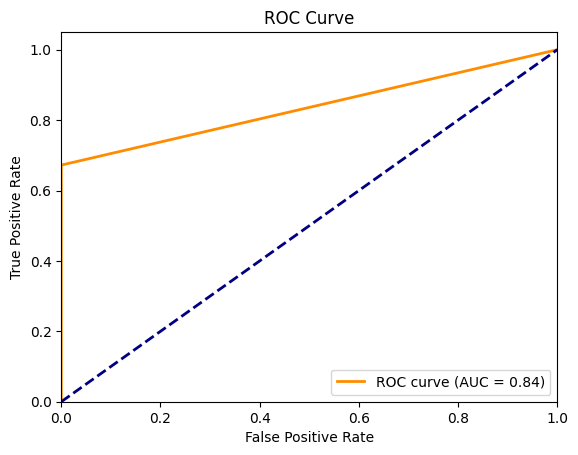

In [78]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(auc_score))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

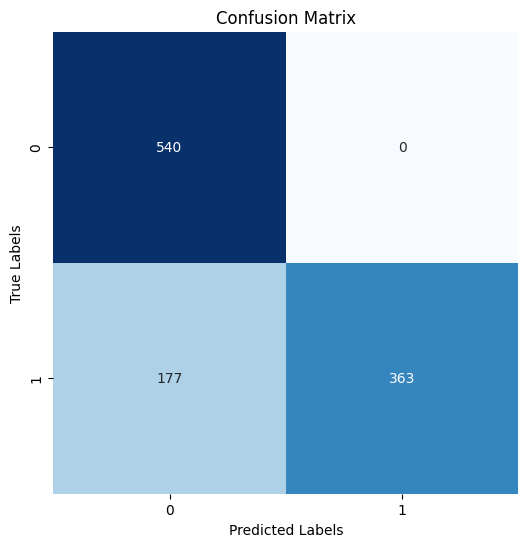

              precision    recall  f1-score   support

           0       0.75      1.00      0.86       540
           1       1.00      0.67      0.80       540

    accuracy                           0.84      1080
   macro avg       0.88      0.84      0.83      1080
weighted avg       0.88      0.84      0.83      1080



In [79]:
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()
print(classification_report(test_labels_list, test_preds_list))